# Modeling Wildfire Tweets
### Table of Contents
- [Imports](#imports)
- [Data](#data)
- [Functions - Vectorizers](#func-vec)
- [Functions - Dimensionality Reduction](#func-dim)
- [Functions - Clustering](#func-cluster)
- [Functions - Visualization](#func-visual)
- [Topic Modeling - LSA](#topic-lsa)
- [Topic Modeling - LDA](#topic-lda)

<a class="anchor" id="imports"></a>
## Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer 
from gensim import corpora, models, similarities, matutils
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn.decomposition import LatentDirichletAllocation

/Users/brittb28/anaconda3/envs/metis/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


![alt text](workflow.png)

<a class="anchor" id="data"></a>
## Data

In [3]:
with open('data/fire_clean.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

## Functions

<a class="anchor" id="func-vec"></a>
#### Vectorizers

<a class="anchor" id="count_vec"></a>
Count Vectorizer

In [4]:
def count_vec(documents):
    '''
    This function takes a corpus of documents and returns a sparse matrix mapping
    words and ngrams to documents. 
    Ex. ["This is a tweet", "Another tweet"]
                        This     is     a .   tweet .   another
    "This is a tweet"     1       1 .   1 .    1 .         0
    "Another tweet"       0 .     0 .   0 .    1 .         1
    
    --------------------------------
    Input: pd Series
    Output: Sparse Matrix
    '''
    # Adding additional stop words
    my_additional_stop_words = ['wildfire', 'like', 'pron']
    stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
    vectorizer = CountVectorizer(ngram_range = (2,3), min_df = 3, max_df = 0.7, stop_words=stop_words, token_pattern = "\\b[a-z][a-z]+\\b")
    doc_word = vectorizer.fit_transform(documents)
    words = vectorizer.get_feature_names()
    id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
    return doc_word, words, id2word

<a class="anchor" id="tfidf"></a>
tf-idf

In [17]:
def tfidf(documents):
    my_additional_stop_words = ['wildfire', 'like', 'pron']
    stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
    cv_tfidf = TfidfVectorizer(analyzer = 'word',ngram_range = (2,3), min_df = 3, stop_words=stop_words, token_pattern = "\\b[a-z][a-z]+\\b") 
    doc_word = cv_tfidf.fit_transform(documents)
    words = cv_tfidf.get_feature_names()
    id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())
    return doc_word, words, id2word, cv_tfidf

In [11]:
doc_word, words, id2word = count_vec(df['text'])

<a class="anchor" id="func-dim"></a>
#### Dimensional Reduction

<a class="anchor" id="lsa"></a>
LSA

In [6]:
def dim_lsa(doc_word, no_topics):
    '''
    This function takes a sparse matrix map of documents to words and reduces the dimensions
    to topics. It returns an array of documents mapped to topics by "relatedness". Each row in the array
    has (no_topics) items in it.
    --------------------
    Inputs: sparse matrix, int
    Outputs: model, array, list
    '''
    lsa = TruncatedSVD(no_topics)
    doc_topic = lsa.fit_transform(doc_word)
    return lsa, doc_topic, lsa.explained_variance_ratio_

In [13]:
lsa, doc_topic, variance = dim_lsa(doc_word, 10)

In [14]:
doc_topic

array([[ 0.98501479, -0.18551606,  0.18958886, ..., -0.04205011,
         0.01012588, -0.02847846],
       [ 0.19075545,  0.22815703, -0.35203939, ...,  0.07540616,
        -0.34973454,  0.05570193],
       [ 0.08761066,  0.05130767, -0.23996302, ..., -0.26960418,
         0.12009253, -0.08828233],
       ...,
       [ 1.01877135, -0.13925951,  0.0149609 , ...,  0.163988  ,
        -0.10524165,  0.22523437],
       [ 0.0950898 ,  0.07097962, -0.12327627, ...,  0.01154855,
        -0.16253182,  0.01161781],
       [ 1.06951253, -0.00336677, -0.03423027, ...,  0.00628293,
        -0.4350482 ,  0.00323925]])

<a class="anchor" id="lda"></a>
[LDA](#topic-lda)

In [7]:
def dim_lda(doc_word, id2word):
    corpus = matutils.Sparse2Corpus(doc_word)
    lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5)
    return lda.print_topics

In [20]:
def sk_lda(doc_word, n_topics):
    lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
    doc_topic = lda.fit_transform(doc_word)
    return lda, doc_topic, lda.exp_dirichlet_component_

<a class="anchor" id="func-cluster"></a>
#### Clustering Algorithms

K Means

In [8]:
def km(X, k):
    km = KMeans(n_clusters=k)
    km.fit(X)
    return 

<a class="anchor" id="func-visual"></a>
#### Visualizing

In [9]:
def display_topics(model, words, no_top_words, topic_names=None):
    '''
    This function takes a dim reduction model, words, number of words to display, and topic_names 
    (default= none). It returns strings of topics.
    ----------------
    Input: function, list, int
    Output: strs
    '''
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([words[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [10]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [11]:
def inertia_plot(X, k_max):
    inertias = []
    for k in range(1,k_max):
        km = KMeans(n_clusters=k)
        km.fit(X)
        inertias.append(km.inertia_)
        plt.scatter(k,km.inertia_, color = 'b')
    plt.plot(range(1,k_max),inertias, color = 'b')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    return plt.show()

<a class="anchor" id="topic-lsa"></a>
## LSA Topic Modeling

#### All Data

[Count Vectorizer](#count_vec)

In [21]:
doc_word, words = count_vec(df['text'])

In [22]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

Using unigrams

In [23]:
display_topics(lsa, words, 5)


Topic  0
california, help, people, northern, home

Topic  1
climate, change, climate change, ca, year

Topic  2
climate, california, change, climate change, aoc

Topic  3
help, trump, ca, victim, affect

Topic  4
burn, trump, forest, state, area

Topic  5
home, help, new, burn, los

Topic  6
people, burn, trump, home, federal

Topic  7
home, trump, ca, state, say

Topic  8
power, state, ca, pge, northern

Topic  9
news, trump, new, spread, wind


Using only bigrams and trigrams

In [25]:
doc_word, words = count_vec(df['text'])

In [26]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

In [27]:
display_topics(lsa, words, 5)


Topic  0
climate change, change make, climate change make, change cause, climate change cause

Topic  1
northern california, death toll, toll rise, death toll rise, california death

Topic  2
gender reveal, video gender, video gender reveal, reveal party, gender reveal party

Topic  3
death toll, toll rise, death toll rise, california death, california death toll

Topic  4
aid california, federal aid, federal aid california, continue burn, california devastating

Topic  5
los angeles, southern california, gavin newsom, presidential library, reagan presidential

Topic  6
gavin newsom, gov gavin, gov gavin newsom, grapple blackout, newsom grapple

Topic  7
southern california, presidential library, reagan presidential, reagan presidential library, ronald reagan

Topic  8
california look, dereliction duty, hey aoc, aoc california, hey aoc california

Topic  9
threaten cut, trump threaten, trump threaten cut, funding california, cut federal


[TFIDF](#tfidf)

In [16]:
doc_word, words = tfidf(df['text'])

In [17]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

In [18]:
display_topics(lsa, words, 5)


Topic  0
california, help, people, burn, northern

Topic  1
spread, climate, change, climate change, gender

Topic  2
gender, reveal, gender reveal, video, video gender

Topic  3
spread, gender, video, reveal, gender reveal

Topic  4
death, toll, death toll, rise, toll rise

Topic  5
portugal, spain, kill, portugal spain, people

Topic  6
portugal, spain, kill, california, portugal spain

Topic  7
help, victim, affect, donate, help victim

Topic  8
trump, burn, federal, aid, say

Topic  9
burn, home, help, northern, northern california


Using only bigrams and trigrams tfidf

In [29]:
doc_word, words = tfidf(df['text'])

In [30]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

In [31]:
display_topics(lsa, words, 5)


Topic  0
gender reveal, video gender, video gender reveal, gender reveal cause, reveal cause

Topic  1
death toll, toll rise, death toll rise, california death, california death toll

Topic  2
climate change, climate change make, change make, change cause, climate change cause

Topic  3
federal aid, aid california, federal aid california, california devastating, continue burn

Topic  4
northern california, california force, force evacuation, california kill, deadly northern california

Topic  5
video youtube, youtube playlist, add video, add video youtube, video youtube playlist

Topic  6
dog emerge, emerge alive, family dog, dog emerge alive, family dog emerge

Topic  7
gavin newsom, gov gavin, gov gavin newsom, grapple blackout, newsom grapple

Topic  8
portugal spain, kill portugal, kill portugal spain, spain kill, portugal spain kill

Topic  9
threaten cut, trump threaten, trump threaten cut, funding california, cut federal


#### By Fire - Shasta

In [32]:
doc_word, words = tfidf(df.loc[df['fire'] == 'shasta_2018','text'])

In [33]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

In [34]:
display_topics(lsa, words, 5)


Topic  0
australian firefighter, firefighter shoot, australian firefighter shoot, shoot battle, firefighter shoot battle

Topic  1
climate change, record shift, response record, response record shift, clean energy

Topic  2
climate change, trump right, cause california, admit trump, inadvertently admit

Topic  3
trump right, cause california, admit trump, inadvertently admit, right cause

Topic  4
california highway, abandon truck, abandon truck litter, truck litter, litter california

Topic  5
approve measure, measure pass, pass cost, approve measure pass, california approve measure

Topic  6
safety info, acre contain, official safety info, consult official, official safety

Topic  7
northern california, rage northern, rage northern california, force evacuation, california force

Topic  8
video youtube, youtube video, video youtube playlist, add video, add video youtube

Topic  9
youtube video, rescue california, firefighter adopt, dog rescue, dog rescue california


#### By Fire - Kincade

In [35]:
doc_word, words = count_vec(df.loc[df['fire'] == 'kincade','text'])

In [36]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

In [37]:
display_topics(lsa, words, 5)


Topic  0
climate change, dereliction duty, hey aoc, california look, government dereliction

Topic  1
federal aid, aid california, federal aid california, continue burn, california devastating

Topic  2
gavin newsom, gov gavin, gov gavin newsom, grapple blackout, newsom grapple

Topic  3
los angeles, southern california, presidential library, reagan presidential, reagan presidential library

Topic  4
threaten cut, trump threaten, trump threaten cut, funding california, cut federal

Topic  5
presidential library, reagan presidential, reagan presidential library, southern california, ronald reagan

Topic  6
dereliction duty, hey aoc, california look, aoc california, hey aoc california

Topic  7
gas price, dark spread, spread gas, dark spread gas, spread gas price

Topic  8
statewide emergency, declare statewide, declare statewide emergency, governor declare, state emergency

Topic  9
presidential library, reagan presidential library, reagan presidential, ronald reagan, ronald reagan pre

A fire threatened the reagan library

#### By Fire - nca_2017

In [38]:
doc_word, words = count_vec(df.loc[df['fire'] == 'nca_2017','text'])

In [39]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

In [40]:
display_topics(lsa, words, 5)


Topic  0
death toll, northern california, toll rise, death toll rise, california death

Topic  1
northern california, deadly northern, deadly northern california, california kill, northern california kill

Topic  2
family dog, dog emerge, emerge alive, dog emerge alive, family dog emerge

Topic  3
peanut creator, creator charles, peanut creator charles, charles schulz, creator charles schulz

Topic  4
portugal spain, wine country, kill portugal, kill portugal spain, rage portugal

Topic  5
wine country, california wine, california wine country, californias wine, report progress

Topic  6
santa rosa, duffel bag, dog duffel, dog duffel bag, pound dog

Topic  7
santa rosa, sonoma napa, rosa sonoma, santa rosa sonoma, evacuation santa

Topic  8
death toll, mile wide, toll reach, death toll reach, wide death

Topic  9
deadly california, fierce wind, wind stir, stir deadly california, stir deadly


#### By Fire - sb 2017

In [41]:
doc_word, words = count_vec(df.loc[df['fire'] == 'sb_2017','text'])

In [42]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

In [43]:
display_topics(lsa, words, 5)


Topic  0
year record, disaster year, make costly, hurricane make, costly disaster

Topic  1
mastermatt arisesuperafrica, master matt, wild master, wild master matt, newmusic presenter

Topic  2
southern california, california mudslide, deadly mudslide, heavy rain, mudslide kill

Topic  3
california mudslide, mudslide kill, california mudslide kill, area ravage, kill people

Topic  4
large record, record california, large record california, finally contain, california finally

Topic  5
rebuild puerto, cover damage, end homelessness, fund chip, puerto ricos

Topic  6
dead tree, million dead tree, million dead, prompt fear, tree prompt

Topic  7
weather disaster, disaster billion, weather disaster billion, tornado drought, flooding tornado

Topic  8
sunday january, saturday sunday january, africa tbt, travel dateoneside capetown, travel dateoneside

Topic  9
climate change, deadly weather, drought californias deadly, drought californias, californias deadly weather


#### By Fire - camp

In [44]:
doc_word, words = count_vec(df.loc[df['fire'] == 'camp','text'])

In [45]:
lsa, doc_topic,variance = dim_lsa(doc_word, 10)

In [46]:
display_topics(lsa, words, 5)


Topic  0
gender reveal, video gender, video gender reveal, cause million, reveal cause

Topic  1
climate change, heat wave, hurricane heat, hurricane heat wave, united states

Topic  2
reveal party, gender reveal party, gender reveal, party ignite, reveal party ignite

Topic  3
northern california, death toll, california relief, donate california, aaron rodgers

Topic  4
report warn, federal report, federal report warn, extreme weather, weather disaster

Topic  5
california relief, donate california, donate california relief, kanye west, aaron rodgers

Topic  6
deadly california, ryan zinke, zinke blame, interior secretary, radical environmentalist

Topic  7
border patrol, patrol agent, border patrol agent, genderreveal party, spark arizona

Topic  8
heat wave, hurricane heat, hurricane heat wave, debilitate hurricane, aaron rodgers

Topic  9
donate california relief, kanye west, donate california, california relief, west donate


There was evidently a wildfire in Arizona in November 2018 as well... and it was caused by a gender reveal party

<a class="anchor" id="topic-lda"></a>
## [LDA](#lda)  Topic Modeling

Remember pyldavis

Change n_gram range to (1,2) in tfidf

In [77]:
doc_word, words, id2word = tfidf(df['text'])

In [78]:
doc_word.transpose().shape

(145216, 234267)

In [76]:
len(id2word)

145216

In [ ]:
lda_thing = dim_lda(doc_word.transpose(), id2word)

In [88]:
lda_thing()

2019-11-14 18:10:09,264 : INFO : topic #0 (0.100): 0.015*"donate california" + 0.011*"california smoke" + 0.010*"retweet" + 0.009*"volunteer" + 0.009*"thanksgive" + 0.009*"quality" + 0.008*"gop" + 0.008*"air quality" + 0.008*"devastation" + 0.008*"air"
2019-11-14 18:10:09,268 : INFO : topic #1 (0.100): 0.014*"gender" + 0.012*"gender reveal" + 0.012*"environmentalist" + 0.008*"video" + 0.008*"money" + 0.008*"party" + 0.007*"spread" + 0.007*"start" + 0.006*"video gender" + 0.006*"californiafire"
2019-11-14 18:10:09,272 : INFO : topic #2 (0.100): 0.014*"california" + 0.011*"death" + 0.010*"toll" + 0.009*"campfire" + 0.009*"reveal" + 0.009*"death toll" + 0.009*"miss" + 0.008*"search" + 0.007*"deadly california" + 0.007*"deadly"
2019-11-14 18:10:09,275 : INFO : topic #3 (0.100): 0.010*"rescue" + 0.009*"cat" + 0.009*"california" + 0.009*"kill" + 0.007*"dog" + 0.007*"displace" + 0.006*"dollar" + 0.006*"helicopter" + 0.005*"photo" + 0.005*"housing"
2019-11-14 18:10:09,279 : INFO : topic #4 (0.

[(0,
  '0.015*"donate california" + 0.011*"california smoke" + 0.010*"retweet" + 0.009*"volunteer" + 0.009*"thanksgive" + 0.009*"quality" + 0.008*"gop" + 0.008*"air quality" + 0.008*"devastation" + 0.008*"air"'),
 (1,
  '0.014*"gender" + 0.012*"gender reveal" + 0.012*"environmentalist" + 0.008*"video" + 0.008*"money" + 0.008*"party" + 0.007*"spread" + 0.007*"start" + 0.006*"video gender" + 0.006*"californiafire"'),
 (2,
  '0.014*"california" + 0.011*"death" + 0.010*"toll" + 0.009*"campfire" + 0.009*"reveal" + 0.009*"death toll" + 0.009*"miss" + 0.008*"search" + 0.007*"deadly california" + 0.007*"deadly"'),
 (3,
  '0.010*"rescue" + 0.009*"cat" + 0.009*"california" + 0.009*"kill" + 0.007*"dog" + 0.007*"displace" + 0.006*"dollar" + 0.006*"helicopter" + 0.005*"photo" + 0.005*"housing"'),
 (4,
  '0.014*"california" + 0.008*"help" + 0.007*"relief" + 0.007*"climate" + 0.006*"change" + 0.006*"victim" + 0.005*"thanksgiving" + 0.005*"trump" + 0.005*"climate change" + 0.005*"ca"'),
 (5,
  '0.021*

In [18]:
doc_word, words, id2word, tfidf = tfidf(df.loc[df['fire']=='camp','text'])

In [15]:
lda, doc_topics, explain = sk_lda(doc_word)

In [16]:
display_topics(lda, words, 10)


Topic  0
death toll, california death, california death toll, death toll rise, toll rise, california bad, climate change, trump right, california say, make california

Topic  1
gender reveal, reveal cause, gender reveal cause, cause million, reveal cause million, video gender, video gender reveal, deadly finally, youtube video, finally tame

Topic  2
air quality, kill people, northern california, climate change, california contain, california kill, california kill people, california survivor, fully contain, kill people fully

Topic  3
climate change, california victim, help california, search remain, remain california, search remain california, heavy rain, help california victim, donation relief, family drama

Topic  4
california history, spark arizona, genderreveal party, climate change, deadly california, party spark, deadly destructive, camp deadly, border patrol, deadly california history

Topic  5
california relief, aaron rodgers, donate million, relief effort, rodgers donate, aa

In [1]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [19]:
pyLDAvis.sklearn.prepare(lda, doc_word, tfidf)

2019-11-17 22:00:43,945 : INFO : NumExpr defaulting to 4 threads.
/Users/brittb28/anaconda3/envs/metis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.103022  0.065637       1        1  10.675225
8      0.008211 -0.148914       2        1  10.212921
4      0.058199  0.051043       3        1  10.201049
1      0.193557 -0.067622       4        1  10.175160
9     -0.019442  0.017172       5        1  10.168644
7     -0.090426 -0.051297       6        1   9.874541
0     -0.060723  0.076594       7        1   9.795235
5     -0.102251 -0.111352       8        1   9.712304
2     -0.029782  0.121794       9        1   9.657880
3     -0.060365  0.046945      10        1   9.527041, topic_info=      Category        Freq                  Term       Total  loglift  logprob
23650  Default  119.000000          reveal cause  119.000000  30.0000  30.0000
12023  Default  118.000000   gender reveal cause  118.000000  29.0000  29.0000
12021  Default  261.000000         gender reveal  261.000000  28.0000  28.0000
5131   Default  121.000000         cause million  121.000000  27.0000  27.0000
23653  Default  110.000000  reveal cause million  110.000000  26.0000  26.0000
...        ...         ...                   ...         ...      ...      ...
3955   Topic10   12.315805       california rain   24.272558   1.6726  -6.5032
13349  Topic10   11.569147           help people   28.042350   1.4657  -6.5658
24776  Topic10   11.282958         search victim   24.500990   1.5756  -6.5908
19318  Topic10   10.768460   northern california  123.756767  -0.0907  -6.6375
29422  Topic10   10.578259     victim california   88.095131   0.2314  -6.6553

[530 rows x 6 columns], token_table=       Topic      Freq                          Term
term                                                
10         6  0.173604                  aaron rodger
10         8  0.260406                  aaron rodger
10        10  0.564213                  aaron rodger
13        10  0.918640         aaron rodger donation
15         2  0.036969                 aaron rodgers
...      ...       ...                           ...
31296      7  0.059838                   zinke blame
31296      8  0.359027                   zinke blame
31299      8  0.950043  zinke blame environmentalist
31301      2  0.206974           zinke blame radical
31301      5  0.776154           zinke blame radical

[1060 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 5, 2, 10, 8, 1, 6, 3, 4])

In [18]:
doc_word, words, id2word, tfidf = tfidf(df.loc[df['fire']=='camp','text'])

In [23]:
lda, doc_topics, explain = sk_lda(doc_word, 8)

In [24]:
display_topics(lda, words, 10)


Topic  0
death toll, california death, california death toll, toll rise, death toll rise, climate change, california bad, make california, forest floor, death toll california

Topic  1
gender reveal, reveal cause, gender reveal cause, cause million, video gender, video gender reveal, reveal cause million, california relief, donate california, donate california relief

Topic  2
gender reveal, kill people, climate change, fully contain, baby gender, baby gender reveal, reveal party, air quality, california kill, gender reveal party

Topic  3
climate change, search remain, red cross, remain california, search remain california, social medium, california victim, support california, aaron rodgers, reduce risk

Topic  4
climate change, california history, deadly california, deadly california history, deadly destructive, destructive california, camp deadly, cause california, percent contain, destructive california history

Topic  5
aaron rodgers, donate million, global warming, rodgers donat

## Try Displaying some clusters

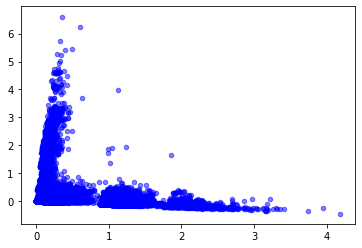

In [55]:
display_cluster(doc_topic)

In [52]:
from sklearn.cluster import KMeans

IndexError: string index out of range

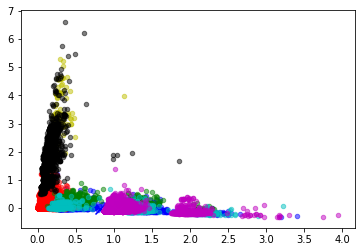

In [53]:
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic,km,num_clusters)

Plot some inertias

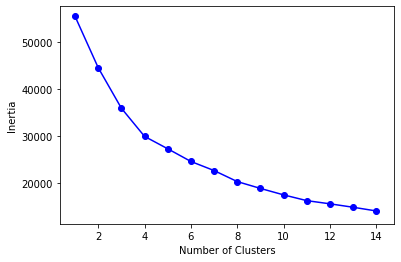

In [54]:
inertia_plot(doc_topic, 15)

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

Inertia makes the assumption that clusters are **convex and isotropic**, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.